In [ ]:
# Run the code without the pump, and calculate the steady-state induced by the probe.
# This reproduces in part the calculations for the previous paper, where the pump
# was not used, and the theory solved for the non-linear equations in the steady-state.
# Use the results to estimate the electronic temperature at selected parameters.

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import json
from datetime import datetime
import multiprocessing as mp
import glob

In [ ]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches': None}

In [2]:
import models.graphene_thermodynamics_v2 as gt
from models.cooling_phonons_v3 import CoolingPhonons
from models.graphene_optics import GrapheneTHG

In [3]:
# Load interpolation data for the calculation of chemical potentials.
mm = gt.mu_func_use_2d_interpolation(load_from="mu_table.pkl")

In [4]:
run_label = "temp_steady_300K"
time_stamp = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
saveDir = "./data/05/%s_%s" % (time_stamp, run_label)
os.mkdir(saveDir)

In [5]:
# One time-evolution with probe pulse.
def oneRun(x):
    dyn = CoolingPhonons(**x["sysparams"])
    runparams = {
        "tmax": 250.0,  # integrate up to a bit later than the end of the probe pulse.
        "tnum": 51,  # need a finer time mesh, possibly aligned with the pulse
        "dt_approx": 5.0,
        "print_time": False    
    }
    dyn.run(**runparams)

    # Save results.
    with open("%s/params-%02d.json" % (x["saveDir"], x["il"]), "w") as f:
        json.dump({"sysparams": x["sysparams"], "runparams": runparams}, f, indent=4)
        
    np.savetxt("%s/dynamics-%02d.csv" % (x["saveDir"], x["il"]), dyn.dynamics_m, delimiter=",")
    np.savetxt("%s/thg-%02d.csv" % (x["saveDir"], x["il"]), np.c_[dyn.p["pr_tt"],dyn.p["etaTHG"]], delimiter=",")
    
    r = (x["il"], x["sysparams"]["eF"], dyn.p["etaTHG_avg"])
    return r

In [6]:
# Generate a list of parameters to parallelize the calculation.
sysparams = {
    "tempK_eq": 300.0,
    "tau_ph": 1200.0,
    "pu_fluenceSI": 0.0,
    "pu_dt": 50.0,
    "pu_eph": 1.200,
    "pr_delay": 50.0,
    "pr_fluenceSI": 130.0,
    "pr_dt": 150.0,
    "pr_eph": 0.320,
    "nsub": 1.4,  # hBN encapsulated with SiO2 around
    "ntop": 1.4,
    "dtdb": 200.0,
    "ph_en_frac": 1.0,
    "dtdb_cutoff_dens": None
}

sysparams = {
    "tempK_eq": 30.0,
    "tau_ph": 1200.0,
    "pu_fluenceSI": 5.0,
    "pu_dt": 110.0,
    "pu_eph": 1.200,
    "pr_fluenceSI": 10.0,
    "pr_dt": 150.0,
    "pr_eph": 0.320,
    "nsub": 1.4,  # hBN encapsulated with SiO2 around
    "ntop": 1.4,
    "gammaConst": 0.0,
    "gammaProp": 0.0,
    "gammaInv": 0.0,
    "dtdb": 45.0,
    "ph_en_frac": 1.0,
    "dtdb_cutoff_dens": None
}


# List of Fermi energies [eV].
eF_list = [0.050, 0.100, 0.150, 0.200, 0.250]
np.savetxt("%s/eF_list.csv" % saveDir, eF_list, delimiter=",")

# Create a list of parameters, one for each run.
params_list = []
for il,eF in enumerate(eF_list):
    params_list.append({"il": il, "saveDir": saveDir, "sysparams": {**sysparams, "eF": eF}})


In [7]:
# Run the calculation and save the results.
with mp.Pool(5) as p:
    res_list = p.map(oneRun, params_list)

In [8]:
# Load the evolutions.
dynamics = []
for i in range(len(params_list)):
    dynamics.append(np.loadtxt("%s/dynamics-%02d.csv" % (saveDir, i), delimiter=","))

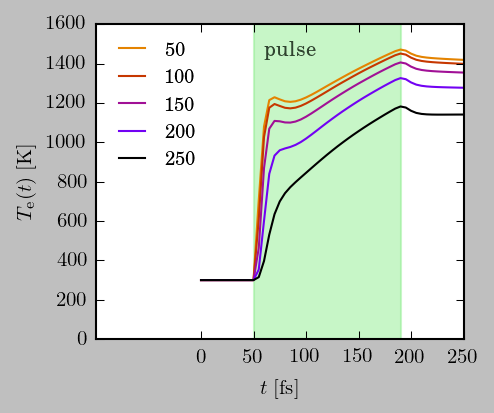

In [10]:
# Plot the temperature as a function of time in the various cases.

mpl.style.use(["classic", "latex"])
cmap = mpl.cm.get_cmap('gnuplot_r')
plt.figure(figsize=(3.5,3.0), frameon=True, dpi=150)
plt.axes([0.2, 0.2, 0.7, 0.7])
plt.axvspan(50.0, 190.0, alpha=0.5, color="#90ee90")
for i,(eF,dyn) in enumerate(zip(eF_list, dynamics)):
    plt.plot(dyn[:,0], dyn[:,1], "-", color=cmap((i+1)/len(dynamics)),
             label="%3.0f" % (eF*1.0e+3) )
plt.xlim([-100.0, 250.0])
plt.ylim([0.0, 1600])
plt.xlabel(r"$t~[{\rm fs}]$")
plt.ylabel(r"$T_{\rm e}(t)~[{\rm K}]$")
plt.xticks([0.0, 50.0, 100.0, 150.0, 200.0, 250.0])
plt.legend(frameon=False,loc="upper left", fontsize=9)
plt.figtext(0.52, 0.83, "pulse", color="#304430")
plt.savefig("%s/temperature_in_time.png" % saveDir, dpi=300)

In [11]:
# For each run, determine the value of the temperature at the end of the pulse.
# Create a table with Fermi energy, temperature, and value of the THG.
# Notice that the label of the runs is the same as the index of the parameter list.
tsteady = 190.0
temp_steady = []
for eF,dyn in zip(eF_list,dynamics):
    it0 = np.abs(dyn[:,0] - tsteady).argmin()
    temp_steady.append([eF, dyn[it0,1]])
# To each line, append the corresponding value of the THG.
for r in res_list:
    temp_steady[r[0]].append(r[2])
temp_steady = np.array(temp_steady)
np.savetxt("%s/temp_steady.csv" % saveDir, temp_steady, delimiter=",")

In [12]:
print(temp_steady)

[[5.00000000e-02 1.47099273e+03 5.93712659e-09]
 [1.00000000e-01 1.45074938e+03 6.10981293e-09]
 [1.50000000e-01 1.40553691e+03 6.57425185e-09]
 [2.00000000e-01 1.32592497e+03 7.83409258e-09]
 [2.50000000e-01 1.18184151e+03 1.18394060e-08]]


In [14]:
# Compare the value of the THG signal for two temperatures.
thg_30K = np.loadtxt("data/05/2023-07-15-17-10-27_temp_steady_30K/temp_steady.csv", delimiter=",")
thg_300K = np.loadtxt("data/05/2023-07-15-17-13-53_temp_steady_300K/temp_steady.csv", delimiter=",")

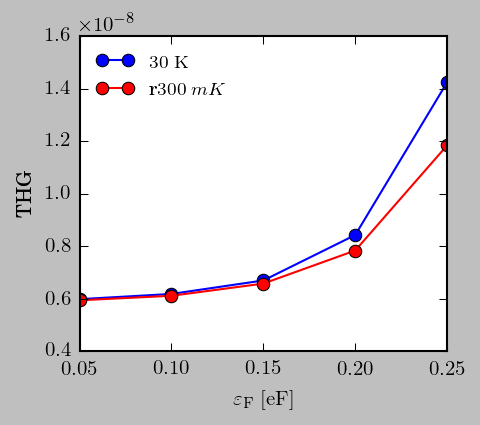

In [17]:
mpl.style.use(["classic", "latex"])
plt.figure(figsize=(3.5,3.0), frameon=True, dpi=150)
plt.axes([0.2, 0.2, 0.7, 0.7])
plt.plot(thg_30K[:,0], thg_30K[:,2], "-ob", label=r"$30~{\rm K}$")
plt.plot(thg_300K[:,0], thg_300K[:,2], "-or", label=r"$300~{\rm K}$")
#plt.xlim([-100.0, 250.0])
#plt.ylim([0.0, 1600])
plt.xlabel(r"$\varepsilon_{\rm F}~[{\rm eF}]$")
plt.ylabel(r"THG")
plt.legend(frameon=False,loc="upper left", fontsize=9)
plt.savefig("data/05/THG_vs_eF_two_temps.png", dpi=300)